In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load data
data_folder = 'email_csv2'
all_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
df_list = []
for file in all_files:
    file_path = os.path.join(data_folder, file)
    df_temp = pd.read_csv(file_path)
    df_temp['source_file'] = file
    df_list.append(df_temp)

# Combine all DataFrames into one
df_all = pd.concat(df_list, ignore_index=True)
print("Total rows across all CSVs:", df_all.shape[0])
print("Total files read:", len(all_files))

Total rows across all CSVs: 161014
Total files read: 160


In [7]:
# Convert the 'date' column to datetime format with UTC timezone
df_all['date_fixed'] = df_all['date'].str.replace(r'\bUT\b', '+0000', regex=True)
df_all['date_fixed'] = df_all['date_fixed'].str.replace(r'\bGMT\b', '+0000', regex=True)
df_all['date_fixed'] = df_all['date_fixed'].str.replace(r'\bEDT\b', '-0400', regex=True)
df_all['date_fixed'] = df_all['date_fixed'].str.replace(r'\bEST\b', '-0500', regex=True)
df_all['date_fixed'] = df_all['date_fixed'].str.replace(r'\s00?100\b', ' +0100', regex=True)
df_all['date_fixed'] = df_all['date_fixed'].str.replace(r'\bMET[-+]?\d?\b', ' +0100', regex=True)

df_all['date_parsed'] = pd.to_datetime(df_all['date_fixed'], errors='coerce', utc=True)
print(df_all[['date', 'date_parsed']].head())

# Check for parsing errors
print("Missing parsed dates:", df_all['date_parsed'].isna().sum())

                              date               date_parsed
0  Wed, 12 Apr 2017 13:54:18 +0000 2017-04-12 13:54:18+00:00
1  Wed, 12 Apr 2017 13:49:31 +0000 2017-04-12 13:49:31+00:00
2  Tue, 30 Jan 2001 13:47:30 -0000 2001-01-30 13:47:30+00:00
3  Thu, 11 Jan 2001 18:37:15 +0100 2001-01-11 17:37:15+00:00
4  Tue, 31 Jul 2001 14:03:18 +0800 2001-07-31 06:03:18+00:00
Missing parsed dates: 0


In [9]:
# Extract domain from emails
def extract_domain_from_email(email: str) -> str:
    if pd.isnull(email) or '@' not in str(email):
        return None
    email = str(email).replace('<', '').replace('>', '').strip()
    domain = email.split('@')[-1].split(':')[0].lower()
    return domain
df_all['from_domain'] = df_all['from'].apply(extract_domain_from_email)
print("Unique domains:", df_all['from_domain'].nunique())

unique_senders = df_all['from'].nunique()
print(f"unique senders: {unique_senders}")

# Count the number of unique subjects
def clean_subject(subject):
    if pd.isnull(subject):
        return ""
    subject = subject.lower().strip()
    while subject.startswith(('re:', 'fw:', 'fwd:', 'aw:', 'antwort:', '答复:', '回复:', 'r:', 'sv:', 'vs:')):
        subject = subject.split(':', 1)[-1].strip()
    return subject

df_all['clean_subject'] = df_all['subject'].apply(clean_subject)
print("Unique subjects:", df_all['clean_subject'].nunique())

Unique domains: 1249
unique senders: 6971
Unique subjects: 62459


C:\Users\Fan\AppData\Local\Temp\ipykernel_15800\3232378299.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_all['year_month'] = df_all['date_parsed'].dt.to_period('M')


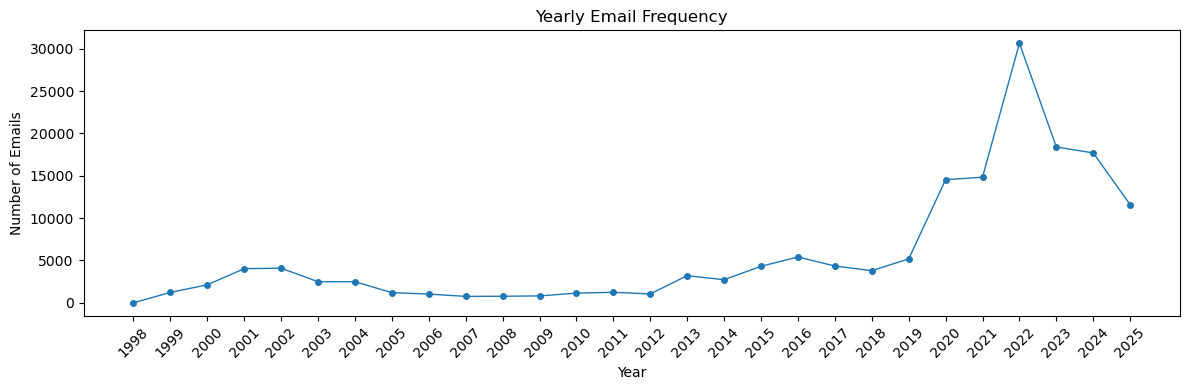

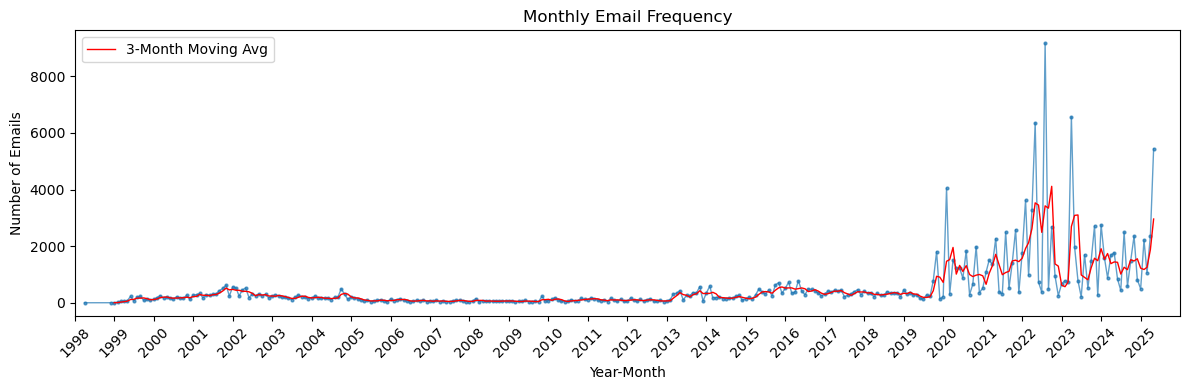

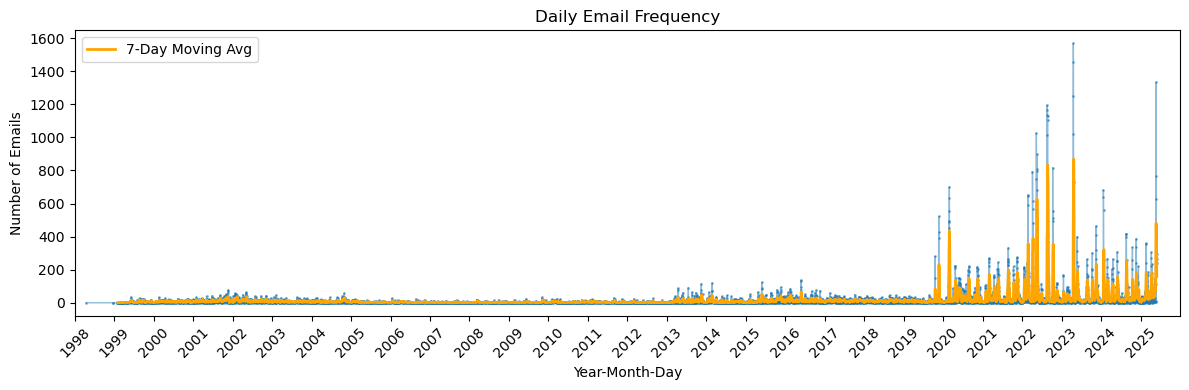

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Extract date components and compute frequency counts (daily, monthly, yearly)
df_all['date_only'] = df_all['date_parsed'].dt.date
daily_counts = df_all['date_only'].value_counts().sort_index()

df_all['year_month'] = df_all['date_parsed'].dt.to_period('M')
monthly_counts = df_all['year_month'].value_counts().sort_index()

df_all['year'] = df_all['date_parsed'].dt.year
yearly_counts = df_all['year'].value_counts().sort_index()

# Yearly email volume line chart
dates_yearly = yearly_counts.index.astype(int)
counts_yearly = yearly_counts.values
plt.figure(figsize=(12,4))
plt.plot(dates_yearly, counts_yearly, marker='o', markersize=4, linewidth=1, alpha=1)
plt.title('Yearly Email Frequency')
plt.xlabel('Year')
plt.ylabel('Number of Emails')
plt.xticks(dates_yearly, dates_yearly.astype(str), rotation=45)
plt.tight_layout()
plt.show()

# Monthly email volume line chart
dates_monthly = monthly_counts.index.to_timestamp()
counts_monthly = monthly_counts.values
rolling_monthly = monthly_counts.rolling(window=3).mean()
plt.figure(figsize=(12,4))
plt.plot(dates_monthly, counts_monthly, marker='o', markersize=2, linewidth=1, alpha=0.7)
plt.plot(dates_monthly, rolling_monthly, label='3-Month Moving Avg', color='red', linewidth=1)
plt.title('Monthly Email Frequency')
plt.xlabel('Year-Month')
plt.ylabel('Number of Emails')
ax = plt.gca()
ax.set_xlim([datetime(1998, 1, 1), datetime(2025, 12, 31)])
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Daily email volume line chart
dates_daily = pd.to_datetime(daily_counts.index)
counts_daily = daily_counts.values
rolling_daily = daily_counts.rolling(window=7).mean()
plt.figure(figsize=(12,4))
plt.plot(dates_daily, counts_daily, marker='o', markersize=1, linewidth=1, alpha=0.5)
plt.plot(dates_daily, rolling_daily, label='7-Day Moving Avg', color='orange', linewidth=2)
plt.title('Daily Email Frequency')
plt.xlabel('Year-Month-Day')
plt.ylabel('Number of Emails')
ax = plt.gca()
ax.set_xlim([datetime(1998, 1, 1), datetime(2025, 12, 31)])
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

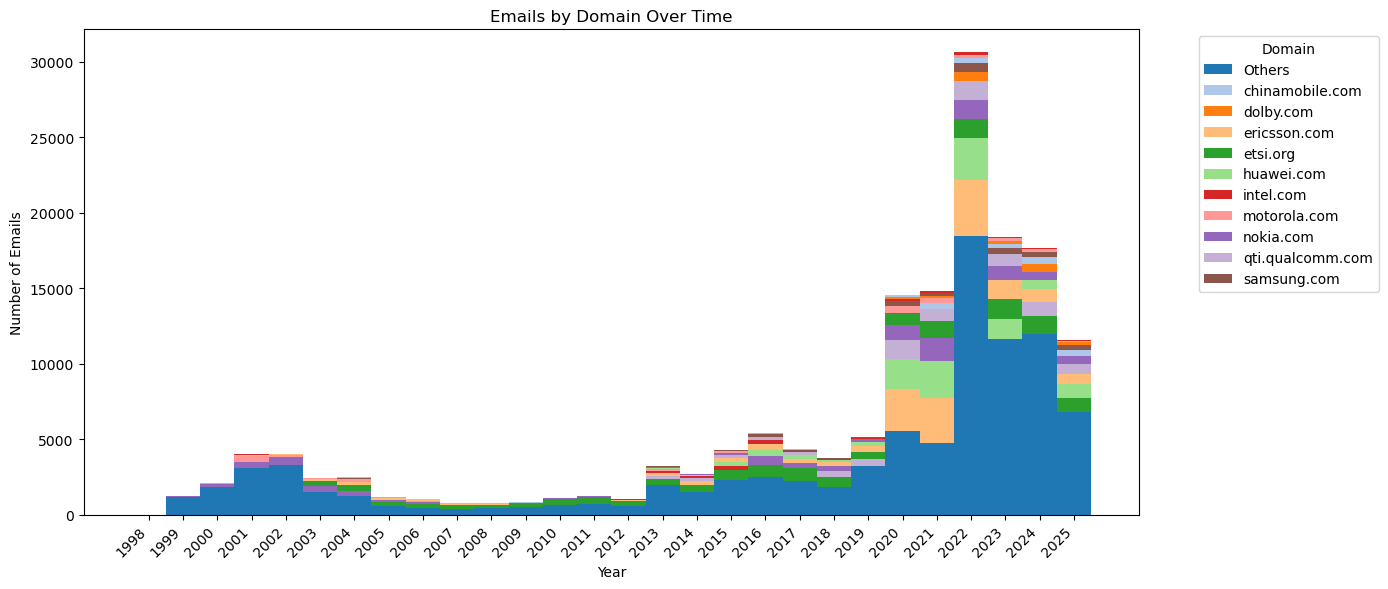

In [15]:
import matplotlib.pyplot as plt

df_processed = df_all.copy()
df_processed['date_parsed'] = pd.to_datetime(df_processed['date'], errors='coerce', utc=True)
df_processed['year'] = df_processed['date_parsed'].dt.year
df_processed = df_processed.dropna(subset=['year'])
df_processed['year'] = df_processed['year'].astype(int)

# 1. Draw a stacked bar chart of "domain and time"
top_domains = df_processed['from_domain'].value_counts().head(10).index.tolist()
df_processed['domain_grouped'] = df_processed['from_domain'].apply(
    lambda d: d if d in top_domains else 'Others'
)
pivot_domain = df_processed.groupby(['year', 'domain_grouped']).size().unstack(fill_value=0)
pivot_domain = pivot_domain.fillna(0)
pivot_domain.index = pivot_domain.index.astype(int)

colors = plt.cm.tab20.colors
dom_cats = pivot_domain.columns.tolist()
dom_color_map = {cat: colors[i % len(colors)] for i, cat in enumerate(dom_cats)}

plt.figure(figsize=(14, 6))
years = sorted(pivot_domain.index.tolist())
for i, year in enumerate(years):
    counts = pivot_domain.loc[year]
    ordered_cats = counts.sort_values(ascending=False).index.tolist()
    bottom = 0
    for cat in ordered_cats:
        val = counts[cat]
        plt.bar(i, val, bottom=bottom, color=dom_color_map[cat], width=1, label=cat if i == 0 else "")
        bottom += val

plt.xticks(range(len(years)), [str(y) for y in years], rotation=45, ha='right')
plt.xlabel('Year')
plt.ylabel('Number of Emails')
plt.title('Emails by Domain Over Time')
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), title='Domain', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [6]:
df_country_map = pd.read_csv('domain_country.csv', encoding='ISO-8859-1')
df_all = df_all.merge(df_country_map, left_on='from_domain', right_on='domain', how='left')
df_processed = df_all.copy()
print("Unique countries:", df_all['country'].nunique())

Unique countries: 61


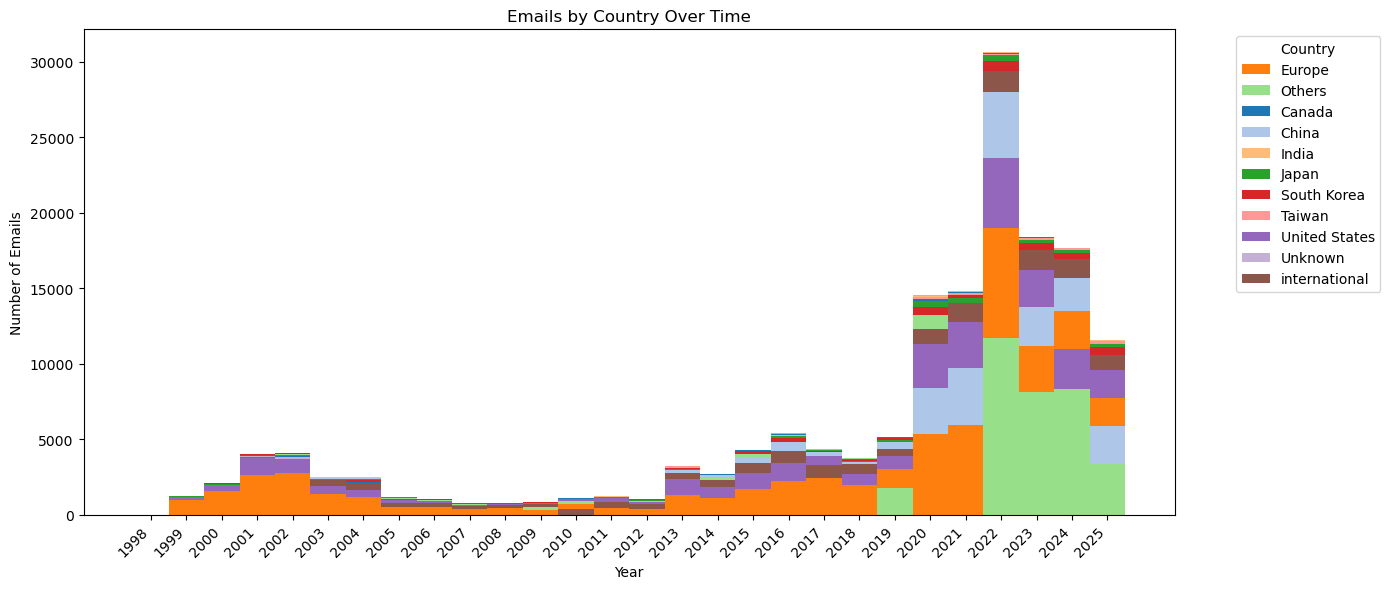

In [7]:
# 2. Draw a stacked bar chart of "country and time" (EU)
european_countries = {
    'Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan','Belarus', 'Belgium', 
    'Bosnia and Herzegovina', 'Bulgaria','Croatia', 'Cyprus', 'Czech Republic', 
    'Denmark', 'Estonia','Finland', 'France', 'Georgia', 'Germany', 'Greece', 
    'Hungary','Iceland', 'Ireland', 'Italy', 'Kazakhstan', 'Kosovo', 'Latvia',
    'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova','Monaco', 
    'Montenegro', 'Netherlands', 'North Macedonia', 'Norway','Poland', 'Portugal', 
    'Romania', 'Russia', 'San Marino', 'Serbia','Slovakia', 'Slovenia', 'Spain', 
    'Sweden', 'Switzerland','Turkey', 'Ukraine', 'Vatican City', 'United Kingdom',
    'Europe', 'European Union'
}

df_processed['country_europe_grouped'] = df_processed['country'].apply(
    lambda c: 'Europe' if c in european_countries else c
)
top_countries = df_processed['country_europe_grouped'].value_counts().head(10).index.tolist()
df_processed['country_top_grouped'] = df_processed['country_europe_grouped'].apply(
    lambda c: c if c in top_countries else 'Others'
)
pivot_country = df_processed.groupby(['year', 'country_top_grouped']).size().unstack(fill_value=0)
pivot_country = pivot_country.fillna(0)
pivot_country.index = pivot_country.index.astype(int)

colors = plt.cm.tab20.colors
cou_cats = pivot_country.columns.tolist()
cou_color_map = {cat: colors[i % len(colors)] for i, cat in enumerate(cou_cats)}

plt.figure(figsize=(14, 6))
years = sorted(pivot_country.index.tolist())
for i, year in enumerate(years):
    counts = pivot_country.loc[year]
    ordered_cats = counts.sort_values(ascending=False).index.tolist()
    bottom = 0
    for cat in ordered_cats:
        val = counts[cat]
        plt.bar(i, val, bottom=bottom, color=cou_color_map[cat], width=1, label=cat if i == 0 else "")
        bottom += val

plt.xticks(range(len(years)), [str(y) for y in years], rotation=45, ha='right')
plt.xlabel('Year')
plt.ylabel('Number of Emails')
plt.title('Emails by Country Over Time')
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

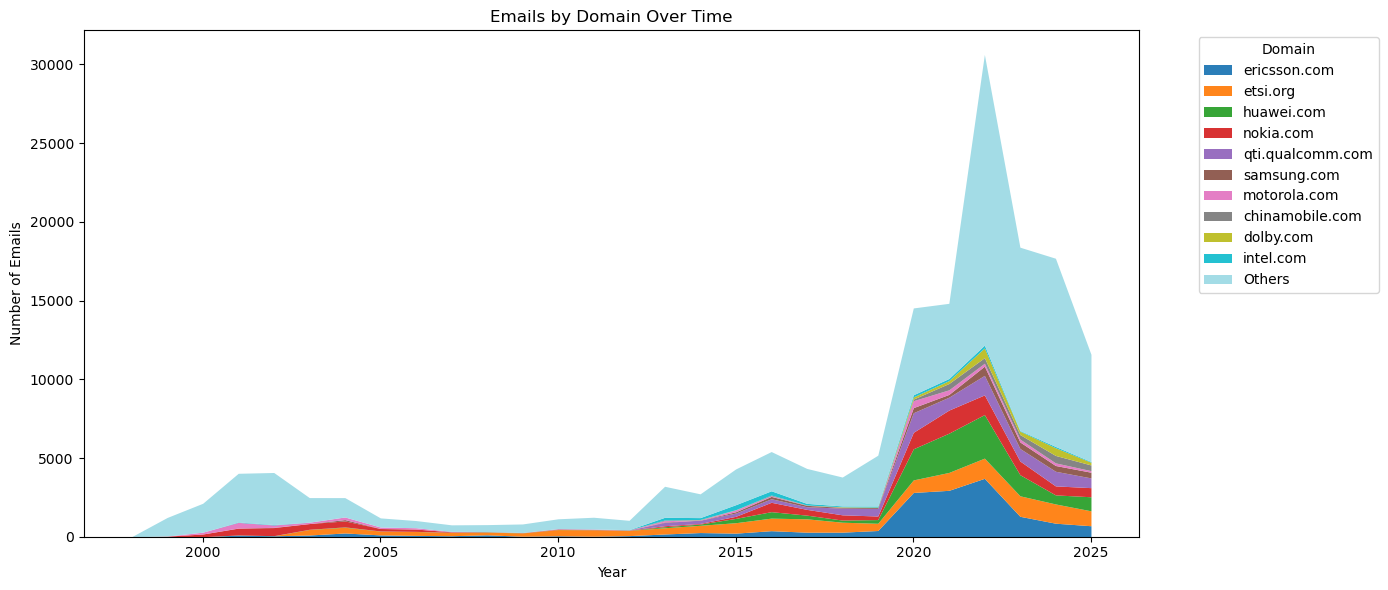

In [8]:
# 3. Stacked Area Chart of Emails by Domain Over Time
top_domains = df_processed['from_domain'].value_counts().head(10).index.tolist()
df_processed['domain_grouped'] = df_processed['from_domain'].apply(
    lambda d: d if d in top_domains else 'Others'
)

pivot_area_domain = df_processed.groupby(['year', 'domain_grouped']).size().unstack(fill_value=0)
pivot_area_domain = pivot_area_domain.sort_index()
pivot_area_domain = pivot_area_domain[top_domains + ['Others']]

ax = pivot_area_domain.plot.area(figsize=(14, 6), colormap='tab20', linewidth=0, alpha=0.95)
plt.title('Emails by Domain Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Emails')
plt.legend(title='Domain', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

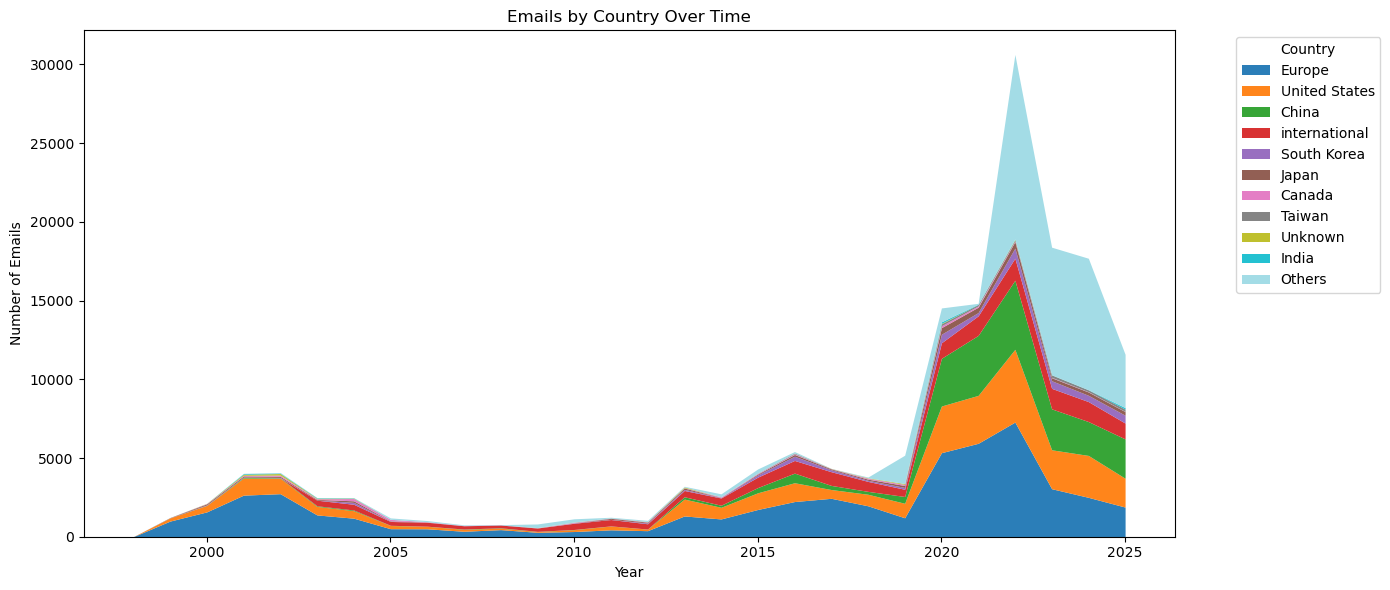

In [9]:
# 4. Stacked Area Chart of Emails by Country Over Time
df_processed['country_europe_grouped'] = df_processed['country'].apply(
    lambda c: 'Europe' if c in european_countries else c
)
top_countries = df_processed['country_europe_grouped'].value_counts().head(10).index.tolist()
df_processed['country_top_grouped'] = df_processed['country_europe_grouped'].apply(
    lambda c: c if c in top_countries else 'Others'
)
pivot_area_country = df_processed.groupby(['year', 'country_top_grouped']).size().unstack(fill_value=0)
pivot_area_country.index = pivot_country.index.astype(int)

if 'Others' in pivot_area_country.columns:
    top_countries = [c for c in top_countries if c != 'Others']
    column_order = top_countries + ['Others']
else:
    column_order = top_countries
pivot_area_country = pivot_area_country[column_order]

ax = pivot_area_country.plot.area(figsize=(14, 6), colormap='tab20', linewidth=0, alpha=0.95)
plt.title('Emails by Country Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Emails')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

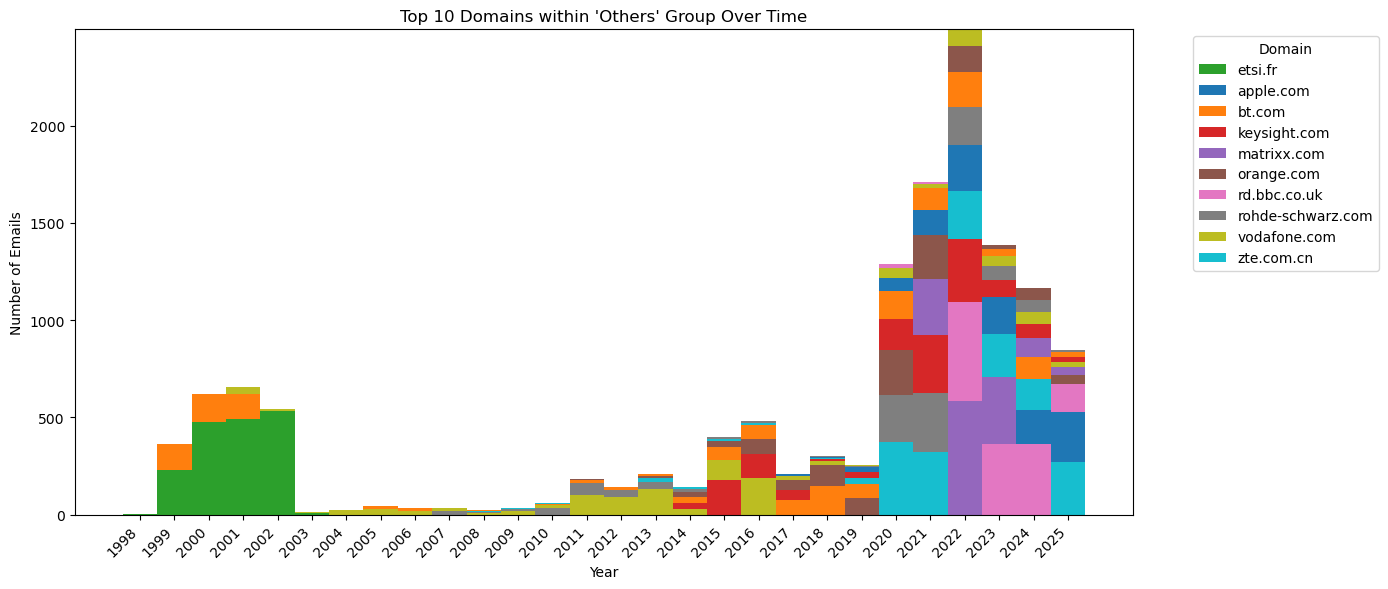

In [10]:
# 1. Top 10 domains within 'Others' group (stacked bar)
others_domain_df = df_processed[df_processed['domain_grouped'] == 'Others']
top_others_domain = others_domain_df['from_domain'].value_counts().head(10).index.tolist()
filtered_domain_df = others_domain_df[others_domain_df['from_domain'].isin(top_others_domain)]

pivot_others_domain = filtered_domain_df.groupby(['year', 'from_domain']).size().unstack(fill_value=0)
pivot_others_domain.index = pivot_others_domain.index.astype(int)

colors = plt.cm.tab10.colors
domain_list = pivot_others_domain.columns.tolist()
color_map = {cat: colors[i % len(colors)] for i, cat in enumerate(domain_list)}

plt.figure(figsize=(14, 6))
years = sorted(pivot_others_domain.index.tolist())
for i, year in enumerate(years):
    counts = pivot_others_domain.loc[year]
    ordered_cats = counts.sort_values(ascending=False).index.tolist()
    bottom = 0
    for cat in ordered_cats:
        val = counts[cat]
        plt.bar(i, val, bottom=bottom, color=color_map[cat], width=1, label=cat if i == 0 else "")
        bottom += val

plt.xticks(range(len(years)), [str(y) for y in years], rotation=45, ha='right')
plt.xlabel('Year')
plt.ylabel('Number of Emails')
plt.title("Top 10 Domains within 'Others' Group Over Time")
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), title='Domain', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

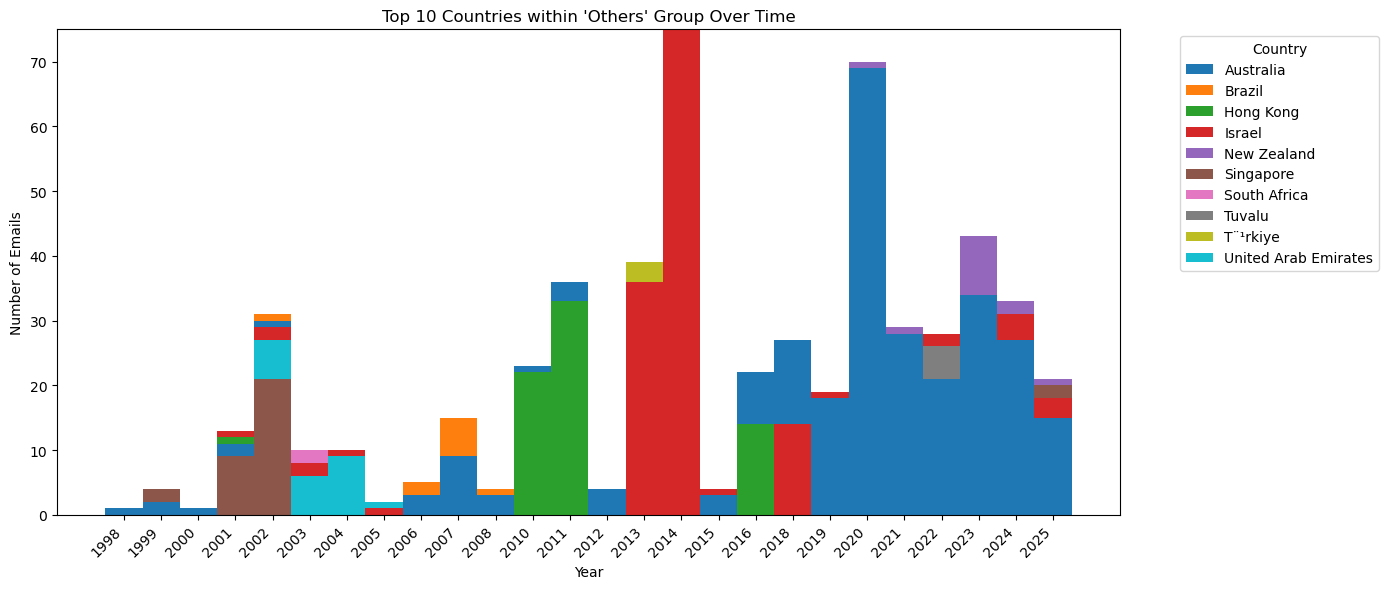

In [11]:
# 2. Top 10 countries within 'Others' group (stacked bar)
others_country_df = df_processed[df_processed['country_top_grouped'] == 'Others']
top_others_country = others_country_df['country'].value_counts().head(10).index.tolist()
filtered_country_df = others_country_df[others_country_df['country'].isin(top_others_country)]

pivot_others_country = filtered_country_df.groupby(['year', 'country']).size().unstack(fill_value=0)
pivot_others_country.index = pivot_others_country.index.astype(int)

colors = plt.cm.tab10.colors
country_list = pivot_others_country.columns.tolist()
color_map = {cat: colors[i % len(colors)] for i, cat in enumerate(country_list)}

plt.figure(figsize=(14, 6))
years = sorted(pivot_others_country.index.tolist())
for i, year in enumerate(years):
    counts = pivot_others_country.loc[year]
    ordered_cats = counts.sort_values(ascending=False).index.tolist()
    bottom = 0
    for cat in ordered_cats:
        val = counts[cat]
        plt.bar(i, val, bottom=bottom, color=color_map[cat], width=1, label=cat if i == 0 else "")
        bottom += val

plt.xticks(range(len(years)), [str(y) for y in years], rotation=45, ha='right')
plt.xlabel('Year')
plt.ylabel('Number of Emails')
plt.title("Top 10 Countries within 'Others' Group Over Time")
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

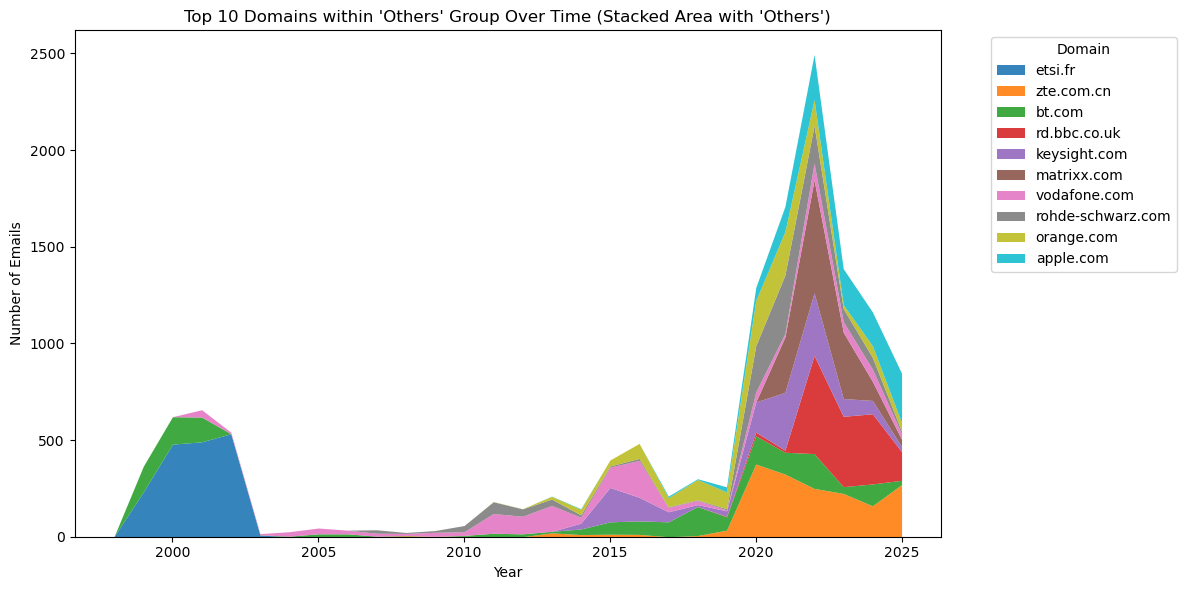

In [12]:
# 3. Top 10 domains within 'Others' group - Area Chart
others_domain_df = df_processed[df_processed['domain_grouped'] == 'Others']
top_others_domain = others_domain_df['from_domain'].value_counts().head(10).index.tolist()
filtered_domain_df = others_domain_df[others_domain_df['from_domain'].isin(top_others_domain)]

pivot_others_domain = filtered_domain_df.groupby(['year', 'from_domain']).size().unstack(fill_value=0)
pivot_others_domain = pivot_others_domain.sort_index()
pivot_others_domain = pivot_others_domain[top_others_domain]

pivot_others_domain.plot.area(figsize=(12, 6), colormap='tab10', linewidth=0, alpha=0.9)
plt.title("Top 10 Domains within 'Others' Group Over Time (Stacked Area with 'Others')")
plt.xlabel("Year")
plt.ylabel("Number of Emails")
plt.legend(title='Domain', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

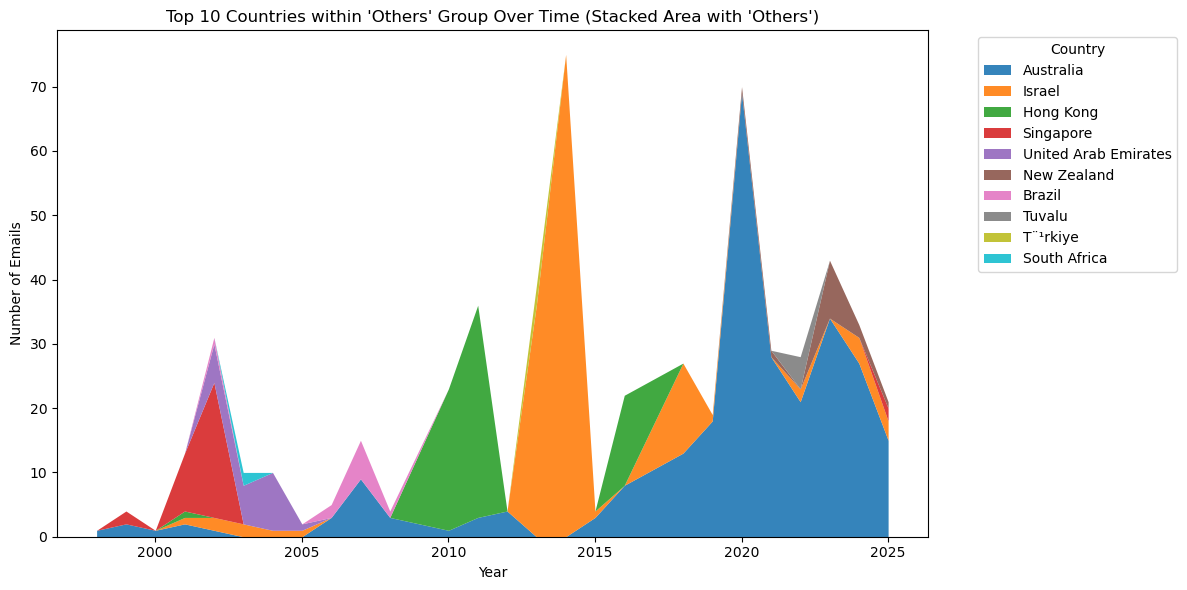

In [13]:
# 4. Top 10 countries within 'Others' group - Area Chart
others_country_df = df_processed[df_processed['country_top_grouped'] == 'Others']
top_others_country = others_country_df['country'].value_counts().head(10).index.tolist()
filtered_country_df = others_country_df[others_country_df['country'].isin(top_others_country)]

pivot_others_country = filtered_country_df.groupby(['year', 'country']).size().unstack(fill_value=0)
pivot_others_country = pivot_others_country.sort_index()
pivot_others_country = pivot_others_country[top_others_country]

pivot_others_country.plot.area(figsize=(12, 6), colormap='tab10', linewidth=0, alpha=0.9)
plt.title("Top 10 Countries within 'Others' Group Over Time (Stacked Area with 'Others')")
plt.xlabel("Year")
plt.ylabel("Number of Emails")
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\Fan\AppData\Local\Temp\ipykernel_1304\2439321543.py:153: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


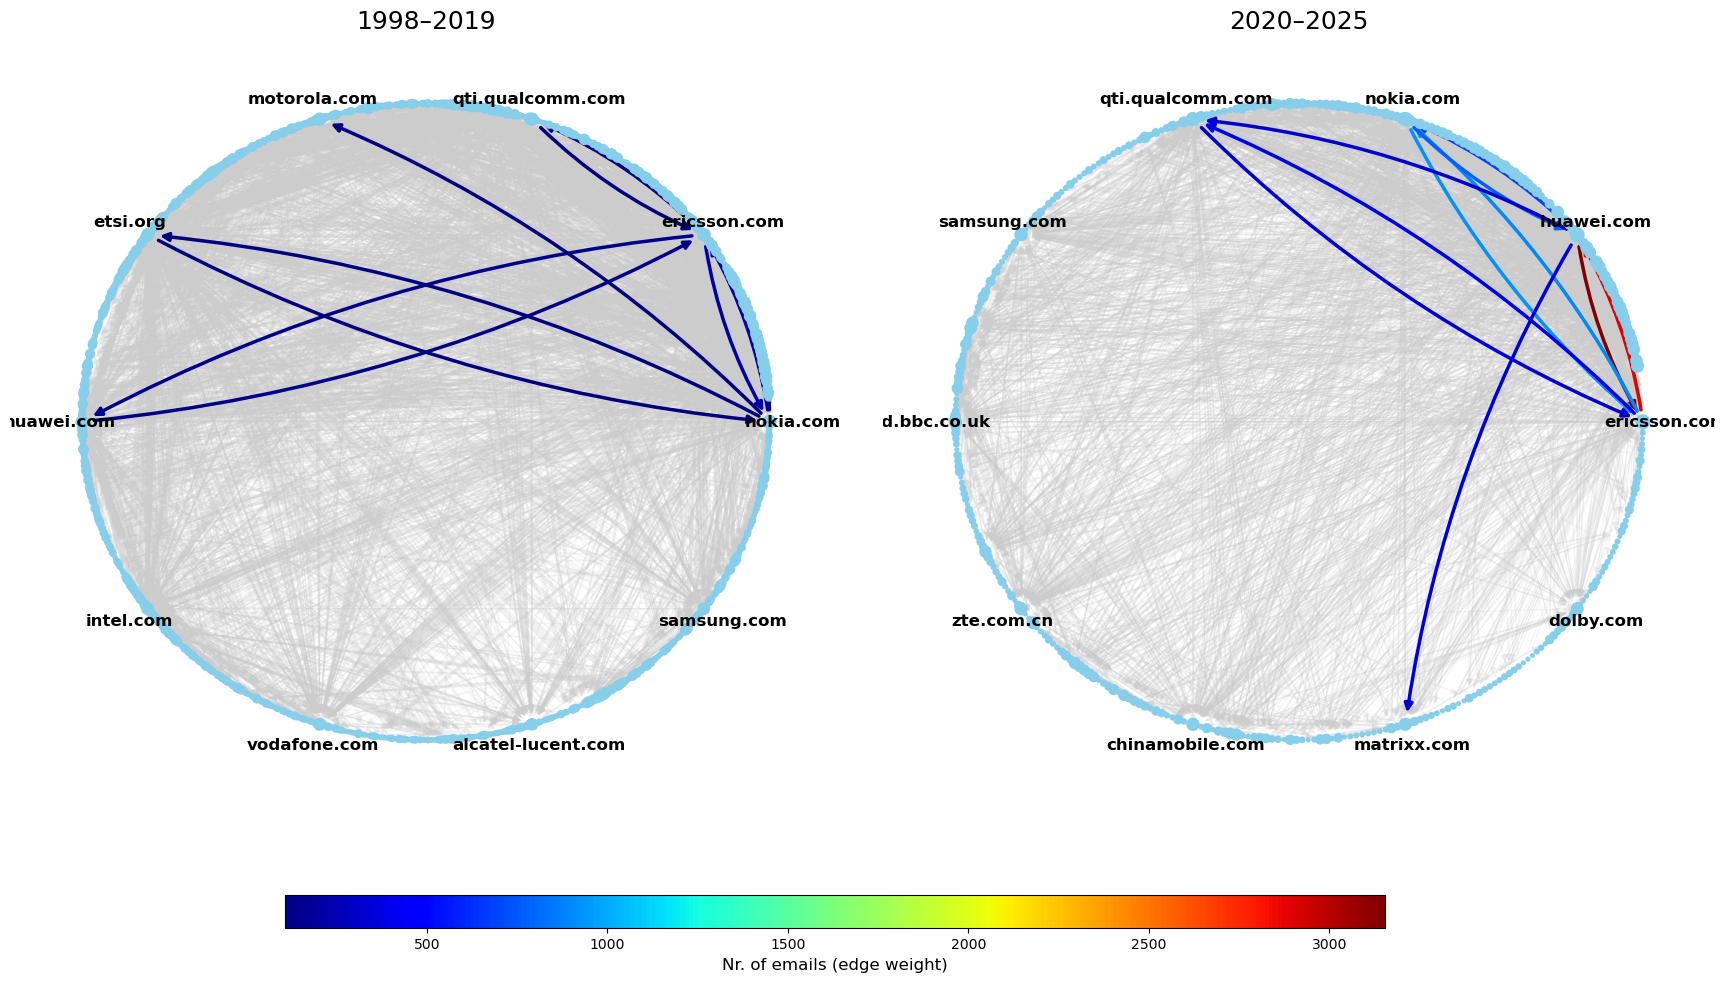

In [14]:
import pandas as pd
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Extract domain
def extract_domain(email):
    if pd.isnull(email) or '@' not in str(email):
        return None
    email = email.replace('<', '').replace('>', '').strip()
    return email.split('@')[-1].lower()
df_all['from_domain'] = df_all['from'].apply(extract_domain)

# Normalize subject
def normalize_subject(subject):
    if pd.isnull(subject):
        return None
    subject = subject.lower().strip()
    pattern = r'^(re:|fw:|fwd:|aw:|antwort:|答复:|回复:|r:|sv:|vs:)\s*'
    subject = re.sub(pattern, '', subject)
    while re.match(pattern, subject):
        subject = re.sub(pattern, '', subject)
    return subject.strip()
df_all['norm_subject'] = df_all['subject'].apply(normalize_subject)

# Extract date
df_all['date_parsed'] = pd.to_datetime(df_all['date_parsed'], errors='coerce', utc=True)
df_all['year'] = df_all['date_parsed'].dt.year

# Label reply
df_all['is_reply'] = df_all['subject'].fillna('').str.lower().str.startswith(('re:', 'fw:', 'fwd:', '答复:', '回复:', 'aw:', 'antwort:', 'r:', 'sv:', 'vs:'))

# Find the original email to confirm comment_to
df_all['comment_to'] = None
for idx, row in df_all[df_all['is_reply']].iterrows():
    norm_subj = row['norm_subject']
    mail_time = row['date_parsed']
    possible_originals = df_all[(df_all['norm_subject'] == norm_subj) & (df_all['date_parsed'] < mail_time)]
    if not possible_originals.empty:
        original = possible_originals.loc[possible_originals['date_parsed'].idxmax()]
        df_all.at[idx, 'comment_to'] = original['from_domain']

# Split into two subsets by year: 1998–2019 and 2020–2025
# 1. year < 2020
df_period1 = df_all[df_all['year'] < 2020].copy()
# 2. year >= 2020
df_period2 = df_all[df_all['year'] >= 2020].copy()

# Define the function
def build_graph_from_df(df):
    G = nx.DiGraph()
    subset = df[
        df['from_domain'].notna() &
        df['comment_to'].notna() &
        (df['from_domain'] != df['comment_to'])
    ]
    for _, row in subset.iterrows():
        u = row['from_domain']
        v = row['comment_to']
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)
    return G

# Construct two periods of graphs separately
G1 = build_graph_from_df(df_period1)  # 1998–2019
G2 = build_graph_from_df(df_period2)  # 2020–2022

# Calculate the "sum of weights" of each node
def node_weight_sum(G):
    wsum = {}
    for n in G.nodes():
        in_sum  = sum([d['weight'] for _, _, d in G.in_edges(n, data=True)])
        out_sum = sum([d['weight'] for _, _, d in G.out_edges(n, data=True)])
        wsum[n] = in_sum + out_sum
    return wsum
wsum1 = node_weight_sum(G1)
top_nodes1 = sorted(wsum1, key=lambda n: wsum1[n], reverse=True)[:10]

# Calculate the weights of all edges
all_edges1 = list(G1.edges(data=True))
top_edges1 = sorted(all_edges1, key=lambda e: e[2]['weight'], reverse=True)[:10]
top_wts1 = [d['weight'] for (_u, _v, d) in top_edges1]

# Select the Top node and Top edge for period2
wsum2 = node_weight_sum(G2)
top_nodes2 = sorted(wsum2, key=lambda n: wsum2[n], reverse=True)[:10]
all_edges2 = list(G2.edges(data=True))
top_edges2 = sorted(all_edges2, key=lambda e: e[2]['weight'], reverse=True)[:10]
top_wts2 = [d['weight'] for (_u, _v, d) in top_edges2]

# Generate a manual "perfectly equally spaced circular layout" function
def circular_layout_manual(G, radius=5, top_nodes=None):
    all_nodes = list(G.nodes())
    N = len(all_nodes)
    if top_nodes is None:
        thetas = np.linspace(0, 2*np.pi, N, endpoint=False)
        pos = {}
        for i, node in enumerate(all_nodes):
            theta = thetas[i]
            pos[node] = (radius * np.cos(theta), radius * np.sin(theta))
        return pos

    # If there are top_nodes, first evenly distribute them to the front part of the circle
    T = list(top_nodes)
    M = len(T)
    if M > N:
        raise ValueError("The number of top_nodes cannot exceed the total number of nodes in G.")

    # Generate M equally divided angles for top_nodes
    top_thetas = np.linspace(0, 2*np.pi, M, endpoint=False)
    pos = {}
    for i, node in enumerate(T):
        theta = top_thetas[i]
        pos[node] = (radius * np.cos(theta), radius * np.sin(theta))

    # The number of remaining nodes
    remaining_nodes = [n for n in all_nodes if n not in top_nodes]
    R = len(remaining_nodes)
    if R > 0:
        thetas_all = np.linspace(0, 2*np.pi, N, endpoint=False)
        rem_thetas = list(thetas_all[M:])
        for i, node in enumerate(remaining_nodes):
            theta = rem_thetas[i]
            pos[node] = (radius * np.cos(theta), radius * np.sin(theta))
    return pos

# Generate "manual circular layout" for G1 and G2
pos1_manual = circular_layout_manual(G1, radius=6, top_nodes=top_nodes1)
pos2_manual = circular_layout_manual(G2, radius=6, top_nodes=top_nodes2)

# Recalculate node size
def compute_node_sizes(G):
    sizes = []
    for node in G.nodes():
        in_sum  = sum([d['weight'] for _, _, d in G.in_edges(node, data=True)])
        out_sum = sum([d['weight'] for _, _, d in G.out_edges(node, data=True)])
        weight_sum = in_sum + out_sum
        size = np.log1p(weight_sum) * 10
        sizes.append(size)
    return sizes

node_sizes1 = compute_node_sizes(G1)
node_sizes2 = compute_node_sizes(G2)

# Unified colormap normalization
all_top_wts = top_wts1 + top_wts2
norm = mcolors.Normalize(vmin=min(all_top_wts), vmax=max(all_top_wts))
cmap = cm.get_cmap('jet')

# Draw the picture
fig, axes = plt.subplots(1, 2, figsize=(22, 11))
ax1, ax2 = axes

# left picture: 1998–2019
ax = ax1
ax.set_title('1998–2019', fontsize=18)
nx.draw_networkx_edges(G1, pos1_manual, ax=ax, alpha=0.2, edge_color='#cccccc')
nx.draw_networkx_nodes(G1, pos1_manual, ax=ax, node_size=node_sizes1, node_color='skyblue')
labels1, label_pos1 = {}, {}
for n in top_nodes1:
    x, y = pos1_manual[n]
    vec = np.array([x, y])
    if np.linalg.norm(vec) == 0:
        dx, dy = 0.0, 0.0
    else:
        dx, dy = vec / np.linalg.norm(vec)
    offset = 0.4 
    labels1[n] = n
    label_pos1[n] = (x + dx * offset, y + dy * offset)

nx.draw_networkx_labels(G1, label_pos1, labels=labels1, ax=ax, font_size=12, font_weight='bold')
for u, v, d in top_edges1:
    w = d['weight']
    color = cmap(norm(w))
    if G1.has_edge(u, v):
        nx.draw_networkx_edges(G1, pos1_manual, edgelist=[(u, v)], ax=ax, width=2.5,
            edge_color=[color], arrows=True, arrowsize=12, connectionstyle='arc3,rad=0.1')
ax.axis('off')

# Right picture: 2020–2022
ax = ax2
ax.set_title('2020–2025', fontsize=18)
nx.draw_networkx_edges(G2, pos2_manual, ax=ax, alpha=0.2, edge_color='#cccccc')
nx.draw_networkx_nodes(G2, pos2_manual, ax=ax, node_size=node_sizes2, node_color='skyblue')
labels2, label_pos2 = {}, {}
for n in top_nodes2:
    x, y = pos2_manual[n]
    vec = np.array([x, y])
    if np.linalg.norm(vec) == 0:
        dx, dy = 0.0, 0.0
    else:
        dx, dy = vec / np.linalg.norm(vec)
    offset = 0.4
    labels2[n] = n
    label_pos2[n] = (x + dx * offset, y + dy * offset)

nx.draw_networkx_labels(G2, label_pos2, labels=labels2, ax=ax, font_size=12, font_weight='bold')
for u, v, d in top_edges2:
    w = d['weight']
    color = cmap(norm(w))
    if G2.has_edge(u, v):
        nx.draw_networkx_edges(G2, pos2_manual, edgelist=[(u, v)], ax=ax, width=2.5, 
            edge_color=[color], arrows=True, arrowsize=12,connectionstyle='arc3,rad=0.1')
ax.axis('off')

fig.subplots_adjust(bottom=0.18, wspace=0.05)
cax = fig.add_axes([0.25, 0.07, 0.5, 0.03])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
cbar.set_label('Nr. of emails (edge weight)', fontsize=12)
plt.show()

In [15]:
def compute_centrality_measures(G):
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
    closeness = nx.closeness_centrality(G)

    df = pd.DataFrame({
        'Domain': list(G.nodes),
        'Degree Centrality': [degree[n] for n in G.nodes],
        'Betweenness Centrality': [betweenness[n] for n in G.nodes],
        'Eigenvector Centrality': [eigenvector[n] for n in G.nodes],
        'Closeness Centrality': [closeness[n] for n in G.nodes]  
    })
    return df

df_centrality_G1 = compute_centrality_measures(G1)  #1998-2019
df_centrality_G2 = compute_centrality_measures(G2)  #2020-2025
df_compare = df_centrality_G1.merge(df_centrality_G2, on="Domain", suffixes=('_G1', '_G2'))

df_compare.sort_values('Betweenness Centrality_G2', ascending=False).head(20)

,Domain,Degree Centrality_G1,Betweenness Centrality_G1,Eigenvector Centrality_G1,Closeness Centrality_G1,Degree Centrality_G2,Betweenness Centrality_G2,Eigenvector Centrality_G2,Closeness Centrality_G2
9,etsi.org,0.461631,0.202812,0.213765,0.491899,0.591036,0.179678,0.186326,0.536881
0,ericsson.com,0.422062,0.104198,0.240455,0.470883,0.778711,0.149278,0.249296,0.567013
2,huawei.com,0.308153,0.073947,0.193254,0.457446,0.722689,0.136675,0.229812,0.546563
1,nokia.com,0.604317,0.207034,0.293673,0.511889,0.708683,0.123012,0.226132,0.540362
5,qti.qualcomm.com,0.214628,0.031254,0.160183,0.417633,0.593838,0.067994,0.216258,0.520130
25,samsung.com,0.149880,0.011130,0.139450,0.420371,0.434174,0.034685,0.181539,0.487432
11,bt.com,0.220624,0.049149,0.136445,0.436499,0.299720,0.034527,0.127640,0.473584
10,zte.com.cn,0.057554,0.001656,0.075665,0.392315,0.414566,0.029909,0.187591,0.492472
39,chinamobile.com,0.074341,0.001893,0.097117,0.389930,0.352941,0.028624,0.167665,0.481797
80,tno.nl,0.043165,0.001786,0.059968,0.391227,0.274510,0.027005,0.129739,0.464998


In [16]:
# Role identification function
def compute_roles(df_period, G):
    df_roles = pd.DataFrame(index=G.nodes())
    df_roles['in_degree'] = nx.in_degree_centrality(G)
    df_roles['out_degree'] = nx.out_degree_centrality(G)
    df_roles['pagerank'] = nx.pagerank(G, weight='weight')
    df_roles['betweenness'] = nx.betweenness_centrality(G, weight='weight')

    df_roles['original_count'] = df_period[df_period['is_reply'] == False].groupby('from_domain').size()
    df_roles['reply_count'] = df_period[df_period['is_reply'] == True].groupby('from_domain').size()
    df_roles = df_roles.fillna(0)
    
    df_roles['activity'] = df_roles['original_count'] + df_roles['reply_count']
    top_50_orgs = df_roles.sort_values(by='activity', ascending=False).head(50).index
    df_roles['role'] = 'Unclassified'

    df_top50 = df_roles.loc[top_50_orgs].copy()
    pr_q95    = df_top50['pagerank'].quantile(0.95)
    in_deg_q90 = df_top50['in_degree'].quantile(0.90)
    in_deg_q95 = df_top50['in_degree'].quantile(0.95)
    in_deg_q40 = df_top50['in_degree'].quantile(0.40)
    out_deg_q80 = df_top50['out_degree'].quantile(0.80)
    rep_q85   = df_top50['reply_count'].quantile(0.85)
    rep_q60   = df_top50['reply_count'].quantile(0.60)
    orig_q85  = df_top50['original_count'].quantile(0.85)
    orig_q40  = df_top50['original_count'].quantile(0.40)
    btw_q90   = df_top50['betweenness'].quantile(0.90)

    def classify_role(row):
        if row['original_count'] > orig_q85 and row['pagerank'] > pr_q95 and row['in_degree'] > in_deg_q90 and row['reply_count'] > rep_q85:
            return 'Leader'
        elif row['betweenness'] > btw_q90 and row['reply_count'] > rep_q85:
            return 'Broker'
        elif row['reply_count'] > rep_q85 and row['out_degree'] > out_deg_q80:
            return 'Participant'
        elif row['reply_count'] > rep_q60 and row['in_degree'] < in_deg_q40:
            return 'Follower'
        else:
            return 'Observer'

    df_roles.loc[top_50_orgs, 'role'] = df_top50.apply(classify_role, axis=1)
    return df_roles

df_roles_1998_2019 = compute_roles(df_period1, G1)
df_roles_2020_2025 = compute_roles(df_period2, G2)

print(df_roles_1998_2019[['in_degree', 'out_degree', 'pagerank', 'reply_count', 'original_count', 'role']].sort_values(by='role'))
print(df_roles_2020_2025[['in_degree', 'out_degree', 'pagerank', 'reply_count', 'original_count', 'role']].sort_values(by='role'))

df_roles_1998_2019.to_csv("roles_1998_2019.csv")
df_roles_2020_2025.to_csv("roles_2020_2025.csv")

                    in_degree  out_degree  pagerank  reply_count  \
huawei.com           0.167866    0.140288  0.028883        927.0   
motorola.com         0.163070    0.169065  0.027378       1000.0   
teliasonera.com      0.026379    0.029976  0.007252        295.0   
upct.es              0.031175    0.034772  0.006749        295.0   
ericsson.com         0.208633    0.213429  0.053174       2023.0   
...                       ...         ...       ...          ...   
azimuthsystems.com   0.015588    0.016787  0.001080         28.0   
sonymobile.com       0.015588    0.009592  0.000772         16.0   
elektrobit.com       0.013189    0.011990  0.000794         24.0   
qca.qualcomm.com     0.002398    0.003597  0.000253          3.0   
cetecom.fr           0.000000    0.001199  0.000197          1.0   

                    original_count          role  
huawei.com                   636.0        Broker  
motorola.com                 385.0        Broker  
teliasonera.com               

In [17]:
# Find out the changes in the status of the organization between the two periods
valid_orgs = df_roles_1998_2019[
    df_roles_1998_2019['role'] != 'Unclassified'
].index.intersection(
    df_roles_2020_2025[df_roles_2020_2025['role'] != 'Unclassified'].index
)

df_compare_roles = pd.DataFrame({
    'Role_1998_2019': df_roles_1998_2019.loc[valid_orgs, 'role'],
    'Role_2020_2025': df_roles_2020_2025.loc[valid_orgs, 'role']
})

df_compare_roles['Changed'] = df_compare_roles['Role_1998_2019'] != df_compare_roles['Role_2020_2025']
changed = df_compare_roles[df_compare_roles['Changed']]

print(f' Total {len(changed)} organizations had role changes among top players.')
print(changed.head(10))

df_compare_roles.to_csv('role_transition_top50_only.csv', encoding='utf-8-sig')

 Total 7 organizations had role changes among top players.
                 Role_1998_2019 Role_2020_2025  Changed
huawei.com               Broker         Leader     True
qti.qualcomm.com    Participant         Broker     True
intel.com           Participant       Observer     True
etsi.org                 Leader         Broker     True
vodafone.com        Participant       Observer     True
motorola.com             Broker       Observer     True
samsung.com            Observer    Participant     True


In [58]:
def compute_domain_stats(df_all, start_date, end_date):
    df_all['date_parsed'] = pd.to_datetime(df_all['date'], errors='coerce', utc=True)
    df_group = df_all[(df_all['date_parsed'] >= start_date) & (df_all['date_parsed'] <= end_date)].copy()

    def clean_subject(subject):
        if pd.isnull(subject):
            return ""
        subject = subject.lower().strip()
        while subject.startswith(('re:', 'fw:', 'fwd:', 'aw:', 'antwort:', '答复:', '回复:', 'r:', 'sv:', 'vs:')):
            subject = subject.split(':', 1)[-1].strip()
        return subject

    df_group['clean_subject'] = df_group['subject'].apply(clean_subject)
    df_group['is_reply'] = df_group['subject'].str.lower().str.startswith(
        ('re:', 'fw:', 'fwd:', 'aw:', 'antwort:', '答复:', '回复:', 'r:', 'sv:', 'vs:')
    )
    df_group['is_reply'] = df_group['is_reply'].fillna(False).astype(bool)
    df_group['from_domain'] = df_processed['from_domain']

    origin_map = df_group[~df_group['is_reply']].drop_duplicates(subset='clean_subject') \
        .set_index('clean_subject')['from_domain'].to_dict()

    df_group['origin_domain'] = df_group['clean_subject'].map(origin_map)
    df_group['reply_self'] = (df_group['is_reply']) & (df_group['from_domain'] == df_group['origin_domain'])
    df_group['reply_others'] = (df_group['is_reply']) & (df_group['from_domain'] != df_group['origin_domain'])

    domain_stats = pd.DataFrame(df_group['from_domain'].unique(), columns=['domain'])

    domain_stats['initiated_count'] = domain_stats['domain'].map(
        df_group[~df_group['is_reply']]['from_domain'].value_counts()).fillna(0).astype(int)
    domain_stats['reply_self_count'] = domain_stats['domain'].map(
        df_group[df_group['reply_self']]['from_domain'].value_counts()).fillna(0).astype(int)
    domain_stats['reply_others_count'] = domain_stats['domain'].map(
        df_group[df_group['reply_others']]['from_domain'].value_counts()).fillna(0).astype(int)
    domain_stats['got_self_replies_count'] = domain_stats['domain'].map(
        df_group[df_group['reply_self']]['origin_domain'].value_counts()).fillna(0).astype(int)
    domain_stats['got_other_replies_count'] = domain_stats['domain'].map(
        df_group[df_group['reply_others']]['origin_domain'].value_counts()).fillna(0).astype(int)

    domain_stats['total_mails'] = (
        domain_stats['initiated_count'] + domain_stats['reply_self_count'] + domain_stats['reply_others_count']
    )
    domain_stats['Initiation_ratio'] = domain_stats['initiated_count'] / (domain_stats['total_mails'] + 1e-6)
    domain_stats['Reply_ratio'] = domain_stats['reply_others_count'] / (domain_stats['total_mails'] + 1e-6)
    domain_stats['Response_ratio'] = domain_stats['got_other_replies_count'] / (domain_stats['initiated_count'] + 1e-6)
    domain_stats = domain_stats.sort_values(by='total_mails', ascending=False)

    return domain_stats

# Calculate two time periods separately
stats_1998_2019 = compute_domain_stats(df_all, "1998-01-01", "2019-12-31")
stats_2020_2025 = compute_domain_stats(df_all, "2020-01-01", "2025-12-31")

print("Top in 1998–2019:")
print(stats_1998_2019.head(10))

print("\nTop in 2020–2025:")
print(stats_2020_2025.head(10))

C:\Users\Fan\AppData\Local\Temp\ipykernel_1304\2399217494.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_group['is_reply'] = df_group['is_reply'].fillna(False).astype(bool)


Top in 1998–2019:
              domain  initiated_count  reply_self_count  reply_others_count  \
15          ETSI.ORG             5539               482                1161   
5          NOKIA.COM             1451               578                2028   
9       ERICSSON.COM             1087               591                1432   
12  QTI.QUALCOMM.COM              893               406                 622   
1            ETSI.FR             1309                74                 363   
10        HUAWEI.COM              636               331                 596   
44      MOTOROLA.COM              385               151                 849   
14         INTEL.COM              399               392                 407   
0             BT.COM              480                80                 386   
49        LUCENT.COM              503               102                 310   

    got_self_replies_count  got_other_replies_count  total_mails  \
15                     482                  

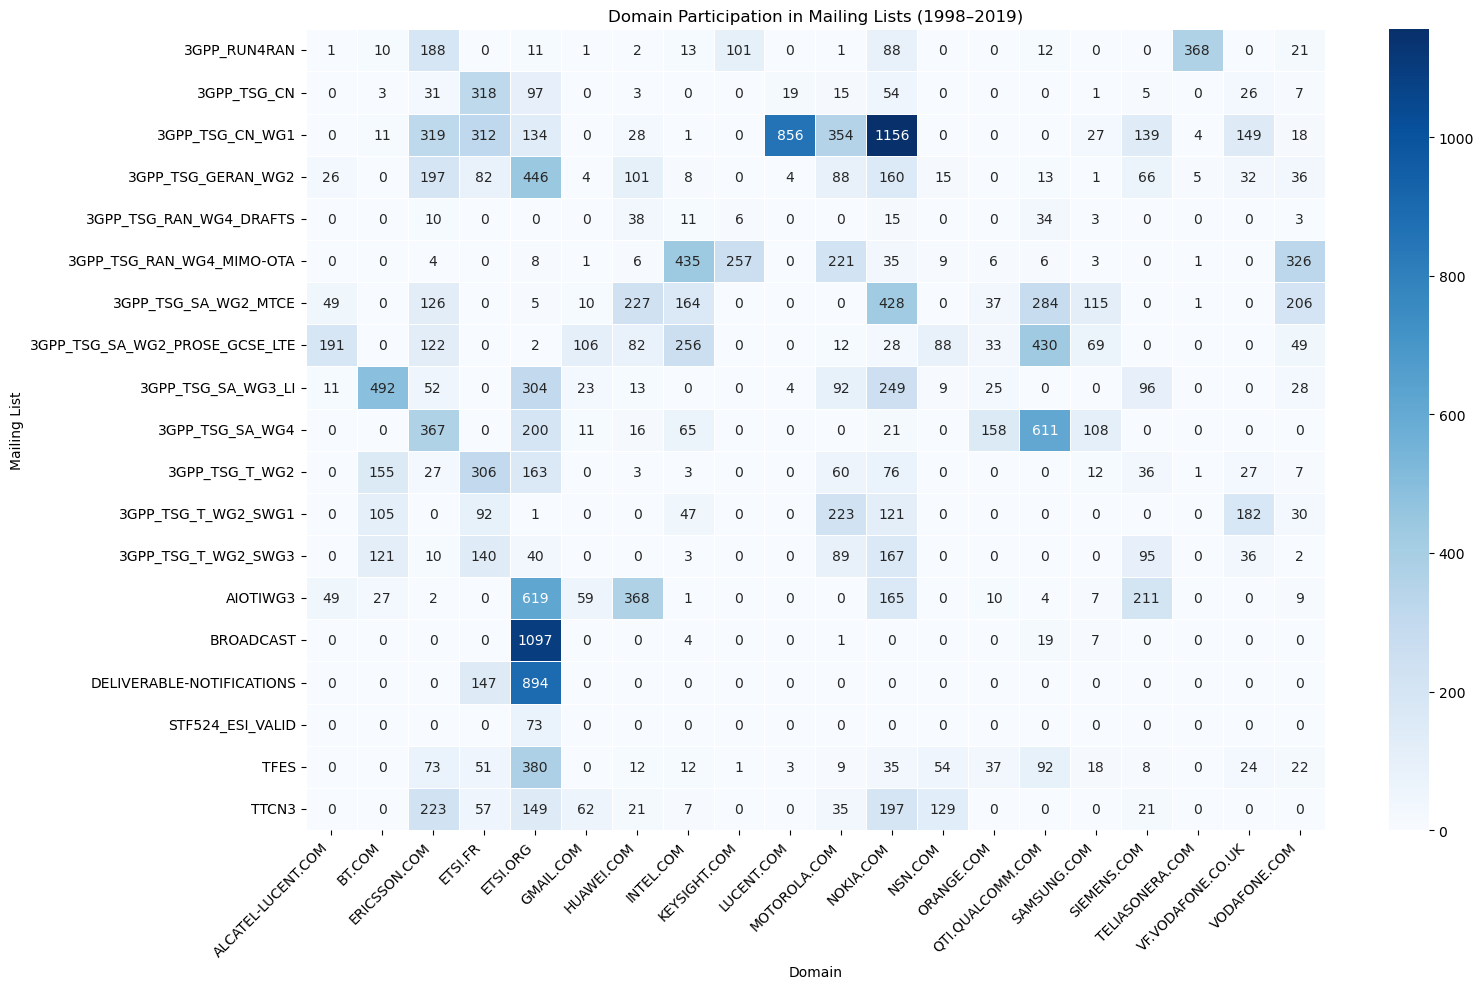

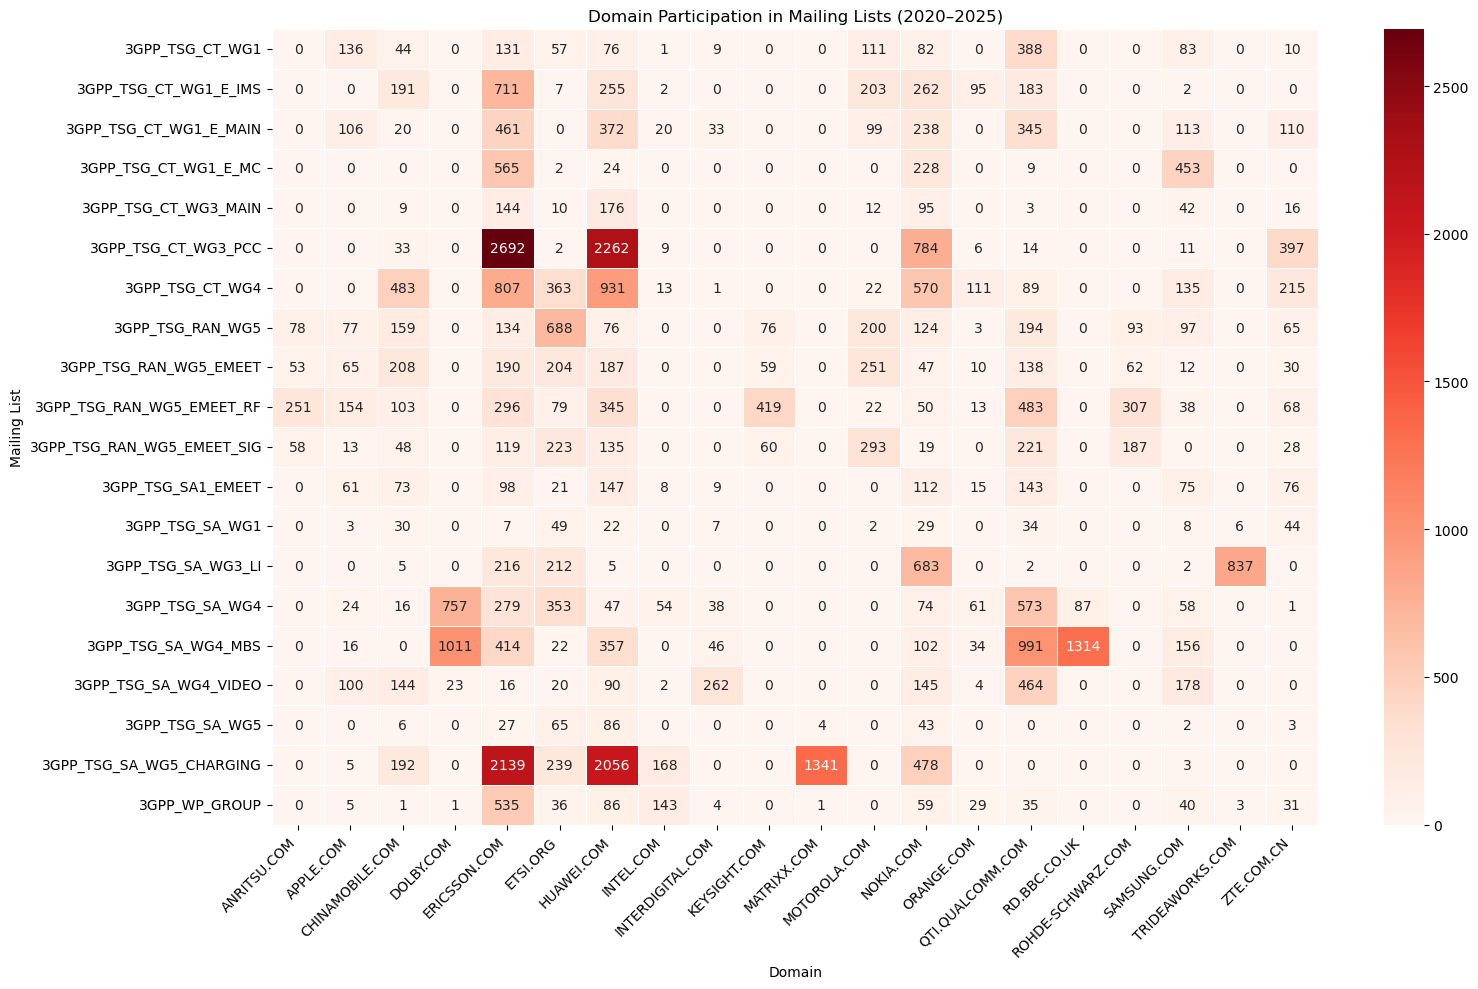

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract domains
df_processed['date_parsed'] = pd.to_datetime(df_processed['date'], errors='coerce', utc=True)
df_processed['from_domain'] = df_processed['from'].str.extract(r'@([\w\.-]+)', expand=False).str.upper()

# Filter data in stages
df_stage1 = df_processed[df_processed['date_parsed'].dt.year < 2020]
df_stage2 = df_processed[df_processed['date_parsed'].dt.year >= 2020]

# Setting heat map parameters (Top 20)
top_lists1 = df_stage1['list_name'].value_counts().head(20).index
top_domains1 = df_stage1['from_domain'].value_counts().head(20).index
df_subset1 = df_stage1[
    df_stage1['list_name'].isin(top_lists1) &
    df_stage1['from_domain'].isin(top_domains1)
]

top_lists2 = df_stage2['list_name'].value_counts().head(20).index
top_domains2 = df_stage2['from_domain'].value_counts().head(20).index
df_subset2 = df_stage2[
    df_stage2['list_name'].isin(top_lists2) &
    df_stage2['from_domain'].isin(top_domains2)
]

heatmap_data1 = df_subset1.groupby(['list_name', 'from_domain']).size().unstack(fill_value=0)
heatmap_data2 = df_subset2.groupby(['list_name', 'from_domain']).size().unstack(fill_value=0)

# Draw a heat map
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data1, cmap='Blues', linewidths=0.5, annot=True, fmt='d')
plt.title("Domain Participation in Mailing Lists (1998–2019)")
plt.xlabel("Domain")
plt.ylabel("Mailing List")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data2, cmap='Reds', linewidths=0.5, annot=True, fmt='d')
plt.title("Domain Participation in Mailing Lists (2020–2025)")
plt.xlabel("Domain")
plt.ylabel("Mailing List")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [31]:
# Analyze the most frequently discussed subjects in a mailing list
pd.set_option('display.max_colwidth', None)
def analyze_group_topics(df, list_name, top_n, sort_by='message_count'):
    def clean_subject(subject):
        if pd.isnull(subject):
            return ""
        subject = subject.lower().strip()
        while subject.startswith(('re:', 'fw:', 'fwd:', 'aw:', 'antwort:', '答复:', '回复:', 'r:', 'sv:', 'vs:')):
            subject = subject.split(':', 1)[-1].strip()
        return subject

    df_group = df[df['list_name'] == list_name].copy()
    df_group['clean_subject'] = df_group['subject'].apply(clean_subject)
    df_group = df_group[df_group['clean_subject'].str.strip() != '']
    df_group['date_parsed'] = pd.to_datetime(df_group['date'], errors='coerce', utc=True)
    df_group = df_group.dropna(subset=['date_parsed'])

    #  Count the number of emails
    total_subjects = df_group['clean_subject'].nunique()
    top_subjects = df_group['clean_subject'].value_counts().head(top_n).reset_index()
    top_subjects.columns = ['clean_subject', 'message_count']

    # Number of participating domains per subject
    domain_per_subject = df_group.groupby('clean_subject')['from_domain'].nunique().reset_index()
    domain_per_subject.columns = ['clean_subject', 'unique_domain_count']

    # Duration of each subject
    duration_per_subject = df_group.groupby('clean_subject')['date_parsed'].agg(['min', 'max']).reset_index()
    duration_per_subject['duration_days'] = (duration_per_subject['max'] - duration_per_subject['min']).dt.days
    duration_per_subject = duration_per_subject[['clean_subject', 'duration_days']]

    # Combine the result
    result = top_subjects.merge(domain_per_subject, on='clean_subject', how='left') \
                         .merge(duration_per_subject, on='clean_subject', how='left')
    sort_by = sort_by.lower()
    if sort_by == 'domain':
        result = result.sort_values(by=['unique_domain_count', 'message_count'], ascending=[False, False])
    elif sort_by == 'duration':
        result = result.sort_values(by=['duration_days', 'message_count'], ascending=[False, False])
    else:
        result = result.sort_values(by='message_count', ascending=False)
    result = result.reset_index(drop=True)
    
    print(f"\n In group [{list_name}]：")
    print(f" Total unique subjects: {total_subjects}")
    print(f"\n Top {top_n} subjects by message count:\n")
    print(result)
    
analyze_group_topics(df_processed, '3GPP_TSG_CN_WG1', top_n=10, sort_by='message_count')


 In group [3GPP_TSG_CN_WG1]：
 Total unique subjects: 2809

 Top 10 subjects by message count:

                                                clean_subject  message_count  \
0                  [ims] 3gpp requirements on sip to the ietf             61   
1  [intersystem change] use of rau on change from umts to gsm             31   
2    conflict between 33.102 (sa3) and 24.008 (cn1) - urgent!             27   
3                            deadline for future cn1 meetings             27   
4                              periodic rau timer deactivated             27   
5                      conf call for ims charging correlation             25   
6                          emergency call discussion document             23   
7                           use of rat in background scanning             23   
8                                          cause #14 in nmo i             23   
9        access independence conference call summary (sep.10)             23   

   unique_domain_count 

In [23]:
df_processed['clean_subject'] = df_processed['subject'].apply(clean_subject)
df_processed['is_reply'] = df_processed['subject'].str.lower().str.startswith(('re:', 'fw:', 'fwd', 'aw:', 'antwort:', '答复:', '回复:', 'r:', 'sv:', 'vs:'))
df_processed['is_reply'] = df_processed['is_reply'].fillna(False).astype(bool)

subject_of_interest = "[ims] 3gpp requirements on sip to the ietf" 
subset = df_processed[df_processed['clean_subject'] == subject_of_interest]
subset = subset.sort_values(by='date_parsed')[['list_name', 'date_parsed', 'from', 'is_reply', 'subject', 'mail_link']]
subset.to_csv("email_content_anlysis.csv", index=False)

pd.set_option('display.max_colwidth', None)
display(subset)

C:\Users\Fan\AppData\Local\Temp\ipykernel_1304\1427180865.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed['is_reply'] = df_processed['is_reply'].fillna(False).astype(bool)


,list_name,date_parsed,from,is_reply,subject,mail_link
7461,3GPP_TSG_CN_WG1,2001-09-03 09:47:47+00:00,"""Miguel A. Garcia"" <Miguel.A.Garcia@ERICSSON.COM>",False,[IMS] 3GPP requirements on SIP to the IETF,https://list.etsi.org/scripts/wa.exe?A2=3GPP_TSG_CN_WG1;65a2a8e0.0109&S=
7460,3GPP_TSG_CN_WG1,2001-09-03 10:26:29+00:00,Allen Andrew-CAA019 <CAA019@MOTOROLA.COM>,True,Re: [IMS] 3GPP requirements on SIP to the IETF,https://list.etsi.org/scripts/wa.exe?A2=3GPP_TSG_CN_WG1;ae55c360.0109&S=
7459,3GPP_TSG_CN_WG1,2001-09-03 10:53:22+00:00,Duncan Mills <duncan.mills@VF.VODAFONE.CO.UK>,True,Re: [IMS] 3GPP requirements on SIP to the IETF,https://list.etsi.org/scripts/wa.exe?A2=3GPP_TSG_CN_WG1;4490123e.0109&S=
7458,3GPP_TSG_CN_WG1,2001-09-03 11:29:55+00:00,"""Drage, Keith (Keith)"" <drage@LUCENT.COM>",True,Re: [IMS] 3GPP requirements on SIP to the IETF,https://list.etsi.org/scripts/wa.exe?A2=3GPP_TSG_CN_WG1;25872dc.0109&S=
7457,3GPP_TSG_CN_WG1,2001-09-03 11:30:36+00:00,"""Miguel A. Garcia"" <Miguel.A.Garcia@ERICSSON.COM>",True,Re: [IMS] 3GPP requirements on SIP to the IETF,https://list.etsi.org/scripts/wa.exe?A2=3GPP_TSG_CN_WG1;7d0d329a.0109&S=
...,...,...,...,...,...,...
7414,3GPP_TSG_CN_WG1,2001-09-17 15:07:28+00:00,Duncan Mills <duncan.mills@VF.VODAFONE.CO.UK>,True,Re: [IMS] 3GPP requirements on SIP to the IETF,https://list.etsi.org/scripts/wa.exe?A2=3GPP_TSG_CN_WG1;fa4cee80.0109&S=
7413,3GPP_TSG_CN_WG1,2001-09-18 10:58:52+00:00,"""Miguel A. Garcia"" <Miguel.A.Garcia@ERICSSON.COM>",True,Re: [IMS] 3GPP requirements on SIP to the IETF,https://list.etsi.org/scripts/wa.exe?A2=3GPP_TSG_CN_WG1;70b6af2e.0109&S=
7412,3GPP_TSG_CN_WG1,2001-09-21 17:47:01+00:00,"""Miguel A. Garcia"" <Miguel.A.Garcia@ERICSSON.COM>",True,Re: [IMS] 3GPP requirements on SIP to the IETF,https://list.etsi.org/scripts/wa.exe?A2=3GPP_TSG_CN_WG1;c0738dea.0109&S=
7222,3GPP_TSG_CN_WG1,2001-09-27 16:39:50+00:00,"""Drage, Keith (Keith)"" <drage@LUCENT.COM>",True,Re: AW: AW: AW: AW: [IMS] 3GPP requirements on SIP to the IETF,https://list.etsi.org/scripts/wa.exe?A2=3GPP_TSG_CN_WG1;368d86b6.0109&S=


In [33]:
# Take TSG_CT_WG3_PCC as an example  
analyze_group_topics(df_processed, '3GPP_TSG_CT_WG3_PCC', top_n=10, sort_by='message_count')


 In group [3GPP_TSG_CT_WG3_PCC]：
 Total unique subjects: 2148

 Top 10 subjects by message count:

                                                                                                                                       clean_subject  \
0                                                       [ens_ph2] [17.18] [c3-2200187] [r0] [impact on ue-slice-mbr when changing the allowed nssai]   
1                                             [ens_ph2] [17.18] [c3-216150] [r1] [cr 0186 29.507 rel-17 rfsp index associated with the target nssai]   
2                                                                [5gs_ph1-ct][15.2.4][c3-211149][r1][correction to the gbr type of default qos flow]   
3                                                [ens_ph2] [17.18] [c3-221148] [r3] [cr 0200 29.507 rel-17 decouple ue-slice-mbr from allowed_nssai]   
4                                                                                         [iiot-ct] [17.16] [c3-212179] [r0] [support surviv

In [35]:
analyze_group_topics(df_processed, '3GPP_TSG_SA_WG5_CHARGING', top_n=10, sort_by='message_count')


 In group [3GPP_TSG_SA_WG5_CHARGING]：
 Total unique subjects: 330

 Top 10 subjects by message count:

                                                                                                                clean_subject  \
0              [sa5#143e] email approval of s5-223722 rel-17 cr 32.255 additional charging message flow for lbo_was_s5-222808   
1                          [sa5#137e], 7.4.2-5g_urllc, s5-213253 rel-17 cr 32.255 correct the message flow for urllc charging   
2                       [sa5#137e], 7.4.3-tei17_niesgu, s5-213148 rel-17 cr 32.255 support of geran-utran access by smf+pgw-c   
3                                           [sa5#137e], 7.4.2-5g_urllc, s5-213256 rel-17 cr 32.255 add rsn for urllc charging   
4                              [sa5#137e], 7.3-maint, s5-213341 rel-16 cr 32.290 correcting of sequence number interpretation   
5                                             [sa5#143e], 7.3-maint, s5-223191 rel-17 cr 32.260 final unit indication miss

In [37]:
analyze_group_topics(df_processed, '3GPP_TSG_SA_WG4_MBS', top_n=10, sort_by='message_count')


 In group [3GPP_TSG_SA_WG4_MBS]：
 Total unique subjects: 223

 Top 10 subjects by message count:

                                                                                                                                                             clean_subject  \
0                   [8.5 rel-17 and earlier/5gms3; 625; block a; 13may 0600 cest] cr ts 26.512-0021 cr for fixing api-version in open api (5gmsa, rel-17) -> for agreement   
1                                                      [8.7 5mbp3; 693; block a; 13may 0600 cest] pcr ts 26.517 bp3]: clause 6: object delivery method -> for agreement   
2                                                      [8.7 5mbp3; 695; block a; 13may 0600 cest] dcr ts 26.346 bp3]: feature reduced flute fdt schema -> for agreement   
3                             [8.5 rel-17/5mbusa; 660; block a; 13may 0530 cest] cr ts 26.502-0003 support of group communication service (5mbusa, rel-17)-> for agreement   
4                                    

In [82]:
df_processed['from_domain'] = df_processed['from'].str.extract(r'@([\w\.-]+)')
df_processed['from_domain'] = df_processed['from_domain'].str.lower()

matrixx_df = df_processed[df_processed['from_domain'] == 'matrixx.com']
dolby_df = df_processed[df_processed['from_domain'] == 'dolby.com']
bbc_df = df_processed[df_processed['from_domain'] == 'rd.bbc.co.uk']

columns_needed = ['list_name', 'subject', 'date_parsed', 'from', 'is_reply', 'mail_link']
matrixx_df = matrixx_df[columns_needed]
dolby_df = dolby_df[columns_needed]
bbc_df = bbc_df[columns_needed]

matrixx_df.to_csv('matrixx_emails.csv', index=False)
dolby_df.to_csv('dolby_emails.csv', index=False)
bbc_df.to_csv('bbc_emails.csv', index=False)

print(f"Matrixx emails: {len(matrixx_df)}")
print(f"Dolby emails: {len(dolby_df)}")
print(f"BBC emails: {len(bbc_df)}")

Matrixx emails: 1350
Dolby emails: 1888
BBC emails: 1416


In [124]:
def clean_subject(subject):
    if pd.isnull(subject):
        return ""
    subject = subject.lower().strip()
    while subject.startswith(('re:', 'fw:', 'fwd:', 'aw:', 'antwort:', '答复:', '回复:', 'r:', 'sv:', 'vs:')):
        subject = subject.split(':', 1)[-1].strip()
    return subject

matrixx_df['clean_subject'] = matrixx_df['subject'].apply(clean_subject)
num_threads = matrixx_df['clean_subject'].nunique()
print(f"total emails: {len(matrixx_df)}")
print(f"unique threads：{num_threads}\n")

top_threads = matrixx_df['clean_subject'].value_counts().head(10)
print("Top active threads：\n")
print(top_threads)


total emails: 1350
unique threads：825

Top active threads：

clean_subject
[sa5#138e] email approval of s5-214668 reply ls on offline charging only indication                                                 10
[sa5#148e], 7.4.1- netslice_ch_ph2, s5-233379 rel-18 pcr 28.203 introduce triggers                                                  10
[sa5#143e] email approval of s5-223722 rel-17 cr 32.255 additional charging message flow for lbo_was_s5-222808                      10
[sa5#145e], 7.5.1-fs_netslice_ch_ph2, s5-225126 rel-18 pcr 32.847 new nsacf (ctf) - ns quota management solution for key issue#1     8
[sa5#148e], 7.4.1- netslice_ch_ph2,s5-233378 rel-18 pcr 28.203 introduce charging scenarios principles                               8
[sa5#145e], 7.5.1-fs_netslice_ch_ph2, s5-225124 rel-18 pcr 32.847 solve editor's note on solution#1.1                                8
[sa5#145e], 7.5.1-fs_netslice_ch_ph2, s5-225127 rel-18 pcr 32.847 evaluation and conclusion for key issue#1         

In [128]:
dolby_df['clean_subject'] = dolby_df['subject'].apply(clean_subject)
num_threads = dolby_df['clean_subject'].nunique()
print(f"total emails: {len(dolby_df)}")
print(f"unique threads：{num_threads}\n")

top_threads = dolby_df['clean_subject'].value_counts().head(10)
print("Top active threads：\n")
print(top_threads)

total emails: 1888
unique threads：1092

Top active threads：

clean_subject
3gpp nwm training                                                                                                                           13
3gpp sa4 mbs swg fs_amd wt#3a offline discussion                                                                                            12
sa4 e-meeting telco schedules                                                                                                                9
[8.5 amd_pro-med; 415; 14 april 1300 cest] cr26.512-0086 [amd_pro-med] media delivery from multiple service locations -> for endorsement     8
3gpp sa4#127-bis-e tdoc deadline                                                                                                             8
sa4#132 initial tdoc allocation                                                                                                              7
[20; - ; plenary; 9 feb 0900] proposed 2022 calendar for 3gpp sa4 m

In [126]:
bbc_df['clean_subject'] = bbc_df['subject'].apply(clean_subject)
num_threads = bbc_df['clean_subject'].nunique()
print(f"total emails: {len(bbc_df)}")
print(f"unique threads：{num_threads}\n")

top_threads = bbc_df['clean_subject'].value_counts().head(10)
print("Top active threads：\n")
print(top_threads)

total emails: 1416
unique threads：762

Top active threads：

clean_subject
[8.10 fs_ms_ns_ph2; 1007; block b; 24aug 1400 cest] pcr tr 26.941 network slicing in sa2 -> for agreement                                                                                                  12
[8.7 5gms_ph2; 989; block a; 19aug 1500 cest] dcr 26.501-xxxx on [5gmsa_ph2] uplink high level procedure -> for agreement                                                                                  11
[8.5 maintenance; 636, 637; 9 april 1300 cest] cr 26.502-0027 / cr 26.517-0013 busa/5mbp3] alignment on support of mbs data reception for ues using power saving functions (rel-18) -> for agreement     9
[8.5 rel-17/5mbusa; 1053; block a; 18aug 1400 cest] dcr 26.502-xxxx on busa] new annex on data model example instantiations -> for agreement                                                             9
[8.5 rel-17 and earlier/5gms3; 625; block a; 13may 0600 cest] cr ts 26.512-0021 cr for fixing api-version in